# Geographic map

Install packages in new env `conda activate geo_env`

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import Point
from geopy.distance import geodesic
import itertools
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import font_manager
import rasterio
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from shapely.geometry import Point
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

/scratch/lfloerl/.condaenvs/geo_env/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Lavaux

In [2]:
df = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv', sep='\t')
df.columns 

Index(['id', 'SAMPLE_NAME', 'Fungal conc. (ng/uL)', 'Collection_ID',
       'sample_type', 'Plot_ID', 'COLLECTION_DATE', 'Replicate', 'Time_point',
       'Year', 'Year_Cat', 'Fermentation_Timepoint', 'Plot', 'Altitude',
       'Average_slope', 'Exposition', 'Min_radiation', 'Max_radiation',
       'Average_radiation', 'Soil_thickness', 'Soil_type', 'Soil_depth',
       'Hydromorphie', 'Hydromorphie_code', 'Geology', 'Coordinates',
       'Latitude', 'Longitude', 'Quadrant', 'Cluster',
       'Plot_PCA_kMeans_Cluster', 'washed'],
      dtype='object')

In [3]:
# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326")

# Convert to web mercator (needed for contextily basemap)
gdf = gdf.to_crs(epsg=3857)

In [4]:
gdf['Plot_ID'].unique()

array(['Lavaux_Plot_4', 'Lavaux_Plot_5', 'Lavaux_Plot_9',
       'Lavaux_Plot_11', 'Lavaux_Plot_12', 'Lavaux_Plot_13',
       'Lavaux_Plot_14', 'Lavaux_Plot_15', 'Lavaux_Plot_18',
       'Lavaux_Plot_19', 'Lavaux_Plot_20', 'Lavaux_Plot_17'], dtype=object)

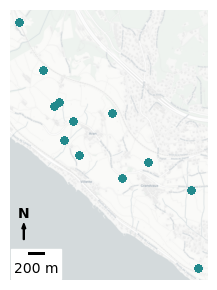

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(4,3))

# colors:  '#481568FF', 2022: '#238A8DFF', 2023: '#FDE725FF'}

gdf.plot(ax=ax, color="#238A8DFF", markersize=20)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, attribution=False)  

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_frame_on(False)

# Add scale bar
scalebar = ScaleBar(1, location='lower left', units='m', length_fraction=0.1)  # Adjust length_fraction as needed
ax.add_artist(scalebar)

# Add north arrow above the scale bar (adjust coordinates)
ax.annotate('N', xy=(0.07, 0.22), xycoords='axes fraction', fontsize=10, fontweight='bold',
            ha='center', va='bottom')
ax.add_patch(mpatches.FancyArrow(0.07, 0.15, 0, 0.04, transform=ax.transAxes, 
                                 color='black', width=0.005, head_width=0.02, head_length=0.02))


plt.tight_layout()
plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/Lavaux-map.png', dpi=1000, bbox_inches='tight', pad_inches=0)
plt.show()

# 3D map Lavaux

In [ ]:
# Load the DEM file using rasterio
dem_file = '/home/lfloerl/cloud/lfloerl/Microterroir/Topography/swissalti3d_2019_2503-1126_0.5_2056_5728.tif'
with rasterio.open(dem_file) as src:
    elevation_data = src.read(1)  # Read the first band (elevation data)
    transform = src.transform  # Geotransform for proper mapping

df = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv', sep='\t')

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326")

# Convert to web mercator (needed for contextily basemap)
gdf = gdf.to_crs(epsg=2056)  # Change CRS to Swiss CH projection

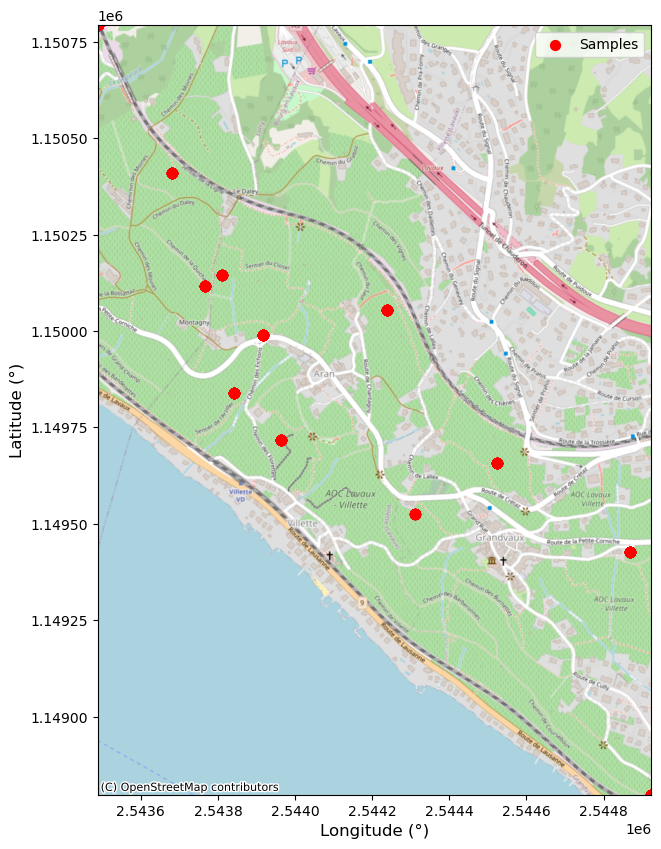

In [66]:
# 3. Define plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the DEM as an image
ax.imshow(elevation_data, cmap='terrain', extent=src.bounds)

# Define contour levels more appropriately (e.g., 10 evenly spaced levels)
contours = ax.contour(elevation_data, levels=np.linspace(np.min(elevation_data), np.max(elevation_data), 20),
                       cmap='viridis', linewidths=0.7)
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.0f')

# Adjust the extent of the map based on your samples' coordinates
min_lon, min_lat, max_lon, max_lat = gdf.total_bounds
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

# 4. Add a basemap (contextily) for background (optional)
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Plot the sample points
gdf.plot(ax=ax, color='red', marker='o', markersize=50, label='Samples')

# Customize plot
ax.set_xlabel('Longitude (°)', fontsize=12)
ax.set_ylabel('Latitude (°)', fontsize=12)

# Add a legend
ax.legend()

# Show the plot
plt.show()

## Get distance 

In [6]:
df_lavaux_valais = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/16S_Valais_and_Lavaux23.tsv', sep="\t")
df_lavaux_valais.head()

,id,SAMPLE_NAME,Domaine,Plot,N-tester_beginning_August,Fertility,Cover_Cropping,07.Jun,27.Jun,17.Jul,...,Latitude,Longitude,Year,CC_Cat,Water_Stress_Cat,Year_Cat,Fermentation_Timepoint,Quadrant,Cluster,Plot_PCA_kMeans_Cluster
0,364527_545-LP3-16S-0545,Valais_60,réseau VS,Venth_2,590.0,1.237410,2.0,NaN,NaN,NaN,...,46.300278,7.533611,2023,CC_2.0,High Water Stress,NaN,NaN,NaN,NaN,NaN
1,364527_546-LP3-16S-0546,Valais_81,réseau VS,Leuk_3,605.0,1.390244,2.0,-1.2,-1.9,-1.8,...,46.314167,7.635278,2023,CC_2.0,Moderate Water Stress,NaN,NaN,NaN,NaN,NaN
2,364527_547-LP3-16S-0547,Valais_68,réseau VS,Géronde_2,601.0,1.816901,2.0,NaN,NaN,NaN,...,46.291944,7.541111,2023,CC_2.0,High Water Stress,NaN,NaN,NaN,NaN,NaN
3,364527_548-LP3-16S-0548,Valais_66,réseau VS,Bernu_2,544.0,1.513333,2.0,-2.3,-3.1,-5.6,...,46.307778,7.558333,2023,CC_2.0,Low Water Stress,NaN,NaN,NaN,NaN,NaN
4,364527_544-LP3-16S-0544,Valais_55,réseau VS,Muraz_1,561.0,1.691667,3.0,-2.1,-3.5,-4.3,...,46.292778,7.522500,2023,CC_3.0,Moderate Water Stress,NaN,NaN,NaN,NaN,NaN


In [7]:
# Convert df_lavaux_valais to a GeoDataFrame
df_lavaux_valais['geometry'] = df_lavaux_valais.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf = gpd.GeoDataFrame(df_lavaux_valais, geometry='geometry')

# Compute pairwise distances and find the maximum
max_distance = 0
max_pair = None

for (i, p1), (j, p2) in itertools.combinations(gdf.iterrows(), 2):
    dist = geodesic((p1['Latitude'], p1['Longitude']), (p2['Latitude'], p2['Longitude'])).kilometers
    if dist > max_distance:
        max_distance = dist
        max_pair = (i, j)

print(f"Max distance Lavaux and Valais: {max_distance:.2f} km between points {max_pair[0]} and {max_pair[1]}")

Max distance Lavaux and Valais: 95.21 km between points 9 and 108


In [8]:
# Convert df_lavaux_valais to a GeoDataFrame
df['geometry'] = df_lavaux_valais.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Compute pairwise distances and find the maximum
max_distance = 0
max_pair = None

for (i, p1), (j, p2) in itertools.combinations(gdf.iterrows(), 2):
    dist = geodesic((p1['Latitude'], p1['Longitude']), (p2['Latitude'], p2['Longitude'])).kilometers
    if dist > max_distance:
        max_distance = dist
        max_pair = (i, j)

print(f"Max distance Lavaux: {max_distance:.2f} km between points {max_pair[0]} and {max_pair[1]}")

Max distance Lavaux: 2.46 km between points 7 and 11


In [9]:
df_within = pd.read_csv("/home/lfloerl/microterroir/Microbiome/Metadata/16S_lavaux_Harvest21.tsv", sep="\t")
df_within.columns

# Convert df to a GeoDataFrame
df_within['geometry'] = df_within.apply(lambda row: Point(row['Long'], row['Lat']), axis=1)
gdf = gpd.GeoDataFrame(df_within, geometry='geometry')

# Function to compute max distance within a plot
def max_distance_within_plot(group):
    max_distance = 0
    for (i, p1), (j, p2) in itertools.combinations(group.iterrows(), 2):
        dist = geodesic((p1['Lat'], p1['Long']), (p2['Lat'], p2['Long'])).meters
        if dist > max_distance:
            max_distance = dist
    return max_distance

# Group by 'Plot_ID' and calculate max distance for each plot
max_distances = gdf.groupby('plot').apply(max_distance_within_plot)

# Find smallest and largest max distances
smallest_max_distance = max_distances.min()
largest_max_distance = max_distances.max()

print(f"Smallest max distance within a plot: {smallest_max_distance:.2f} m")
print(f"Largest max distance within a plot: {largest_max_distance:.2f} m")

Smallest max distance within a plot: 5.47 m
Largest max distance within a plot: 42.16 m


In [10]:
max_distances.median()

25.06806941630149

In [11]:
max_distances.mean()

26.267249308371316

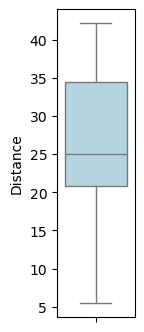

In [19]:
plt.figure(figsize=(1, 4))  # Adjust figure size if needed

sns.boxplot(data=max_distances, color="lightblue")  

plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.xlabel("")  # Label for x-axis
plt.ylabel("Distance")  # Label for y-axis

plt.show()

# Plot Valais and Lavaux

In [9]:
# Convert to GeoDataFrame
gdf_samples = gpd.GeoDataFrame(df_lavaux_valais, geometry=gpd.points_from_xy(df_lavaux_valais.Longitude, df_lavaux_valais.Latitude), crs="EPSG:4326")

# Convert to web mercator (needed for contextily basemap)
gdf_samples = gdf_samples.to_crs(epsg=3857)

In [10]:
gdf_samples['Variety'].unique()

array(['PinotNoir', 'Chasselas'], dtype=object)

In [11]:
# Kanton borders where downloaded in the WINE project 
# Load Shapefile with the region boundaried 
gdf_regions = gpd.read_file("/home/lfloerl/cloud/lfloerl/WINE/Map/swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp")
# Filter for Zürich and Valais
gdf_regions = gdf_regions[gdf_regions['NAME'].isin(["Vaud", "Valais"])]
# convert
gdf_regions = gdf_regions.to_crs(epsg=3857)

In [12]:
# Define colors for the regions (semi-transparent)
region_colors = {"Vaud": "#B8DE29FF", "Valais": "#56C667FF"}
gdf_regions["color"] = gdf_regions["NAME"].map(region_colors).fillna("gray")

# Spatial join to assign canton color to each sample point
gdf_samples = gpd.sjoin(gdf_samples, gdf_regions[["NAME", "geometry", "color"]], how="left", predicate="within")

# Define marker shapes based on variety
marker_shapes = {"PinotNoir": "o", "Chasselas": "^"}  
gdf_samples["marker"] = gdf_samples["Variety"].map(marker_shapes).fillna("o")


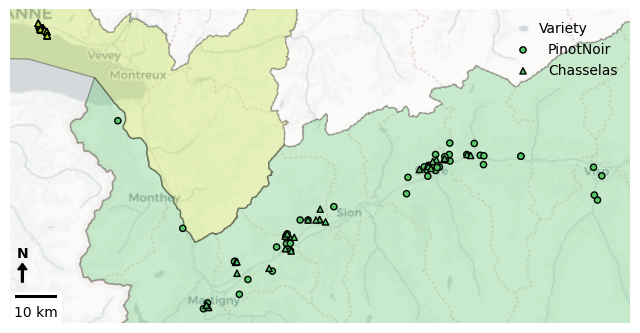

In [13]:
# Plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the canton boundaries
gdf_regions.plot(ax=ax, color=gdf_regions["color"], alpha=0.3, edgecolor="black", linewidth=1)

# Plot sample points with the same color as their respective canton and shape based on variety
for variety, shape in marker_shapes.items():
    variety_samples = gdf_samples[gdf_samples["Variety"] == variety]
    variety_samples.plot(ax=ax, color=variety_samples["color"], marker=shape, markersize=20, edgecolor="black", label=variety)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution=False)

# Set plot limits based on the sample points (bounding box) with padding
minx, miny, maxx, maxy = gdf_samples.total_bounds

# Padding factor (e.g., 0.05 adds 5% extra space)
padding_factor = 0.05

# Calculate padding values
x_padding = (maxx - minx) * padding_factor
y_padding = (maxy - miny) * padding_factor

# Adjust the limits with padding
ax.set_xlim(minx - x_padding, maxx + x_padding)
ax.set_ylim(miny - y_padding, maxy + y_padding)


# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_frame_on(False)

# Add a legend for the variety to the top-right corner
ax.legend(title="Variety", loc="upper right", frameon=False)

# Add scale bar
scalebar = ScaleBar(1, location='lower left', units='m', length_fraction=0.1)  # Adjust length_fraction as needed
ax.add_artist(scalebar)

# Add north arrow above the scale bar (adjust coordinates)
ax.annotate('N', xy=(0.02, 0.2), xycoords='axes fraction', fontsize=10, fontweight='bold',
            ha='center', va='bottom')
ax.add_patch(mpatches.FancyArrow(0.02, 0.13, 0, 0.04, transform=ax.transAxes, 
                                 color='black', width=0.003, head_width=0.015, head_length=0.02))

plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/LavauxValais-map.png', dpi=1000, bbox_inches='tight')

plt.show()

# Plot Switzerland

In [4]:
gdf_switzerland = gpd.read_file("/home/lfloerl/cloud/lfloerl/WINE/Map/swissBOUNDARIES3D_1_5_TLM_LANDESGEBIET.shp")
gdf_switzerland = gdf_switzerland.to_crs(epsg=3857)


# Kanton borders where downloaded in the WINE project 
# Load Shapefile with the region boundaried 
gdf_regions = gpd.read_file("/home/lfloerl/cloud/lfloerl/WINE/Map/swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp")
# Filter for Zürich and Valais
gdf_regions = gdf_regions[gdf_regions['NAME'].isin(["Vaud"])]
# convert
gdf_regions = gdf_regions.to_crs(epsg=3857)

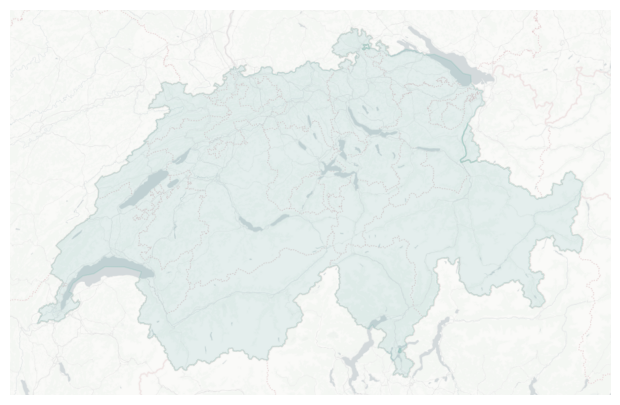

In [39]:
# Plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the canton boundaries
gdf_switzerland.plot(ax=ax, color="#238A8DFF", alpha=0.1, edgecolor="#20A386FF", linewidth=1)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, attribution=False)

# Set plot limits based on the sample points (bounding box) with padding
minx, miny, maxx, maxy = gdf_switzerland.total_bounds

# Padding factor (e.g., 0.05 adds 5% extra space)
padding_factor = 0.05

# Calculate padding values
x_padding = (maxx - minx) * padding_factor
y_padding = (maxy - miny) * padding_factor

# Adjust the limits with padding
ax.set_xlim(minx - x_padding, maxx + x_padding)
ax.set_ylim(miny - y_padding, maxy + y_padding)

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_frame_on(False)


# Add north arrow above the scale bar (adjust coordinates)
#ax.annotate('N', xy=(0.95, 0.1), xycoords='axes fraction', fontsize=10, fontweight='bold',
#            ha='center', va='bottom')
#ax.add_patch(mpatches.FancyArrow(0.95, 0.02, 0, 0.04, transform=ax.transAxes, 
#                                 color='black', width=0.003, head_width=0.015, head_length=0.02))

plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/Swiss-map.png', dpi=1000, bbox_inches='tight')

plt.show()

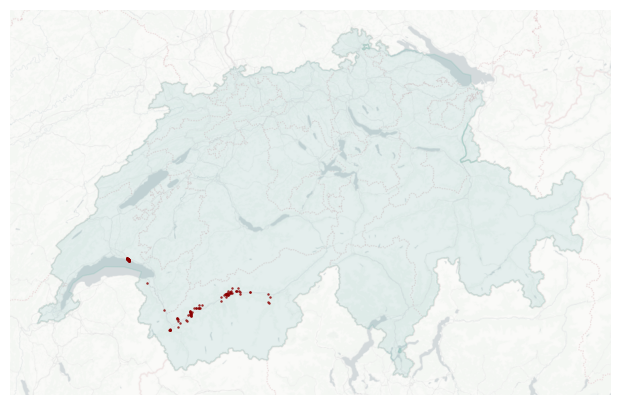

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the canton boundaries
gdf_switzerland.plot(ax=ax, color="#238A8DFF", alpha=0.1, edgecolor="#20A386FF", linewidth=1)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, attribution=False)


# Plot the canton boundaries
gdf_samples.plot(ax=ax, color="#8B0000", alpha=0.8, edgecolor=None, linewidth=0.01, markersize=3)

# Set plot limits based on the sample points (bounding box) with padding
minx, miny, maxx, maxy = gdf_switzerland.total_bounds

# Padding factor (e.g., 0.05 adds 5% extra space)
padding_factor = 0.05

# Calculate padding values
x_padding = (maxx - minx) * padding_factor
y_padding = (maxy - miny) * padding_factor

# Adjust the limits with padding
ax.set_xlim(minx - x_padding, maxx + x_padding)
ax.set_ylim(miny - y_padding, maxy + y_padding)

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_frame_on(False)


# Add north arrow above the scale bar (adjust coordinates)
#ax.annotate('N', xy=(0.95, 0.1), xycoords='axes fraction', fontsize=10, fontweight='bold',
#            ha='center', va='bottom')
#ax.add_patch(mpatches.FancyArrow(0.95, 0.02, 0, 0.04, transform=ax.transAxes, 
#                                 color='black', width=0.003, head_width=0.015, head_length=0.02))

#plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/Swiss-wSamples-map.png', dpi=1000, bbox_inches='tight')

plt.show()

# Plot Romandie

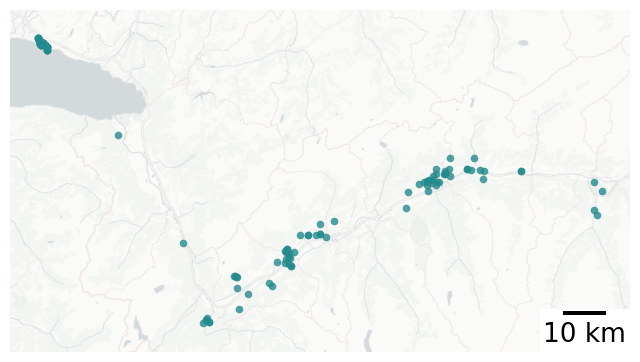

In [18]:
# Plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the canton boundaries
gdf_samples.plot(ax=ax, color="#238A8DFF", alpha=0.8, edgecolor=None, linewidth=0.01, markersize = 30)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, attribution=False)

# Set plot limits based on the sample points (bounding box) with padding
minx, miny, maxx, maxy = gdf_samples.total_bounds


# Calculate padding values
x_padding = (maxx - minx) * 0.05
y_padding = (maxy - miny) * 0.1

# Adjust the limits with padding
ax.set_xlim(minx - x_padding, maxx + x_padding)
ax.set_ylim(miny - y_padding, maxy + y_padding)


# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_frame_on(False)

# Add scale bar
scalebar = ScaleBar(1, 
                    location='lower right', 
                    units='m', 
                    length_fraction=0.1,
                    width_fraction=0.01,
                    font_properties={'size': 19})  
ax.add_artist(scalebar)



# Add north arrow above the scale bar (adjust coordinates)
#ax.annotate('N', xy=(0.95, 0.1), xycoords='axes fraction', fontsize=10, fontweight='bold',
#            ha='center', va='bottom')
#ax.add_patch(mpatches.FancyArrow(0.95, 0.02, 0, 0.04, transform=ax.transAxes, 
#                                 color='black', width=0.003, head_width=0.015, head_length=0.02))

plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/Swiss-wSamples-map.png', dpi=1000, bbox_inches='tight')

plt.show()